# Data preparation/exploration for the Aguathon

## Problem definition

Find the best model that predict the level of the Evro river when cros Zaragoza.

----

## Index

1. [Import modules and Data](#first-bullet)
2. [Data exploration](#second-bullet)
3. [Feature Engineering](#third-bullet)
4. [Missing Values](#fourth-bullet)
   * Split the data in train and test set
5. [Model regressor](#fifth-bullet)
    * Cross-validation

## Import modules and Data <a class="anchor" id="first-bullet"></a>

In [1]:
%load_ext autoreload
%matplotlib inline
#%matplotlib notebook
%autoreload 1


# STD lib imports
import os
import sys

# Third party libs
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# sklear stuff
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error as ecm
from sklearn.metrics import r2_score as r2

# root path of the project
PROJ_ROOT = os.path.join(os.pardir)

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport data.make_dataset
%aimport features.build_features
import data.make_dataset as md
import features.build_features as bf

os.environ['KMP_DUPLICATE_LIB_OK']='True'

print(os.path.abspath(PROJ_ROOT))

# Load data from ITA
raw_file = 'datos.csv'
path = '../ENTRADA/'
df_raw = md.load_data(path, raw_file)

# choose columns
cols = []

# period of the data
start = df_raw.index.min()
end = df_raw.index.max()

idx = df_raw.resample('D').mean().index
print('Shape:', df_raw.shape)
display(df_raw.head())

/Users/miloc/Documents/git-hub/Apsu
Shape: (95856, 10)


,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,pred_24h,pred_48h,pred_72h
time,,,,,,,,,,
2008-01-01 00:00:00,0.8100,0.4375,1.6000,0.2675,0.7875,0.74,False,0.750,0.7400,0.76
2008-01-01 01:00:00,0.8100,0.4725,1.6075,0.2650,0.7900,0.74,False,0.745,0.7325,0.76
2008-01-01 02:00:00,0.8100,0.5425,1.6100,0.2675,0.7900,0.74,False,0.740,0.7300,0.76
2008-01-01 03:00:00,0.8075,0.5500,1.6100,0.2600,0.7900,0.74,False,0.740,0.7200,0.76
2008-01-01 04:00:00,0.8000,0.5525,1.6025,0.2650,0.7900,0.74,False,0.740,0.7200,0.76


In [2]:
# Estation to load data
estaciones = {'pna': '9262-19530901-20190131.csv',  
              'zar_aero':'9434-19410101-20190302.csv'} 

# inputs
cols = ['FECHA','TMEDIA','TMIN','TMAX','PRECIPITACION']
path_meteo = '../data/DatosPorEstacion2019-03-02/DatosPorEstacion/'

# Load meteo data and filter by period
df_meteo = md.load_meteo(path_meteo, estaciones, cols) 
    
# complete hourly data
df_meteo = df_meteo.resample('H').ffill()/24

# Filter by period
df_meteo = df_meteo[(df_meteo.index >= start) & (df_meteo.index <= end)]

print('Shape:', df_meteo.shape)
display(df_meteo.tail())

Shape: (95856, 8)


,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero
FECHA,,,,,,,,
2018-12-07 19:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 20:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 21:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 22:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 23:00:00,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6


In [3]:
# Concatenate both data frames
df = pd.concat([df_raw, df_meteo], axis=1)

print('Shape:', df.shape)
display(df.tail())

Shape: (95856, 18)


,ALAGON_NR,GRISEN_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,pred_24h,pred_48h,pred_72h,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero
2018-12-07 19:00:00,0.9850,0.6950,1.7300,0.52,0.8450,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 20:00:00,0.9800,0.6925,1.7475,0.52,0.8450,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 21:00:00,0.9675,0.6925,1.7500,0.52,0.8375,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 22:00:00,0.9550,0.6925,1.7400,0.52,0.8300,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6
2018-12-07 23:00:00,0.9450,0.6925,1.7375,0.52,0.8300,1.05,False,1.03,1.0,0.99,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6


In [4]:
df.isnull().sum()

ALAGON_NR                 16968
GRISEN_NR                  8710
NOVILLAS_NR                1468
TAUSTE_NR                   519
TUDELA_NR                   277
ZGZ_NR                        0
RIESGO                        0
pred_24h                      0
pred_48h                      0
pred_72h                      0
TMEDIA_pna                   48
TMIN_pna                     24
TMAX_pna                     24
PRECIPITACION_pna            24
TMEDIA_zar_aero               0
TMIN_zar_aero                 0
TMAX_zar_aero                 0
PRECIPITACION_zar_aero        0
dtype: int64

## Data exploration <a class="anchor" id="second-bullet"></a>

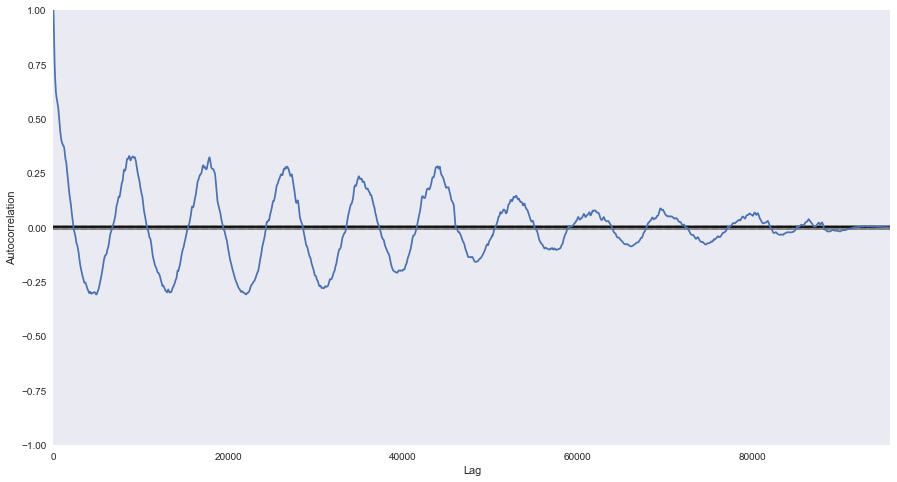

In [5]:
plt.figure(figsize=(15,8))
pd.plotting.autocorrelation_plot(df.ZGZ_NR.fillna(0))

/Users/miloc/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/miloc/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.8175e+04, 6.5440e+03, 5.3100e+03, 3.4870e+03, 1.0292e+04,
        2.0521e+04, 9.9500e+03, 1.8730e+03, 4.0200e+02, 1.1300e+02,
        6.1000e+01, 5.9000e+01, 5.5000e+01, 3.5000e+01, 3.3000e+01,
        2.6000e+01, 3.5000e+01, 1.3000e+01, 1.2000e+01, 1.1000e+01,
        1.2000e+01, 1.1000e+01, 1.2000e+01, 7.0000e+00, 7.0000e+00,
        1.0000e+01, 8.0000e+00, 5.0000e+00, 6.0000e+00, 5.0000e+00,
        8.0000e+00, 1.7000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00, 1.1000e+01]),
 array([0.07    , 0.170125, 0.27025 , 0.370375, 0.4705  , 0.570625,
        0.67075 , 0.770875, 0.871   , 0.971125, 1.07125 , 1.171375,
        1.2715  , 1.371625, 1.47175 , 1.571875, 1.672   , 1.772125,
        1.87225 , 1.972375, 2.0725  , 2.172625, 2.27275 , 2.372875,
        2.473   , 2.573125, 2.67325 , 2.773375, 2.8735  , 2.973625,
        3.07375 , 3.173875, 3.274   , 3.374125, 3.47425 , 3.574375,
        3.6745  , 3.774625, 3.87475 , 3.974875

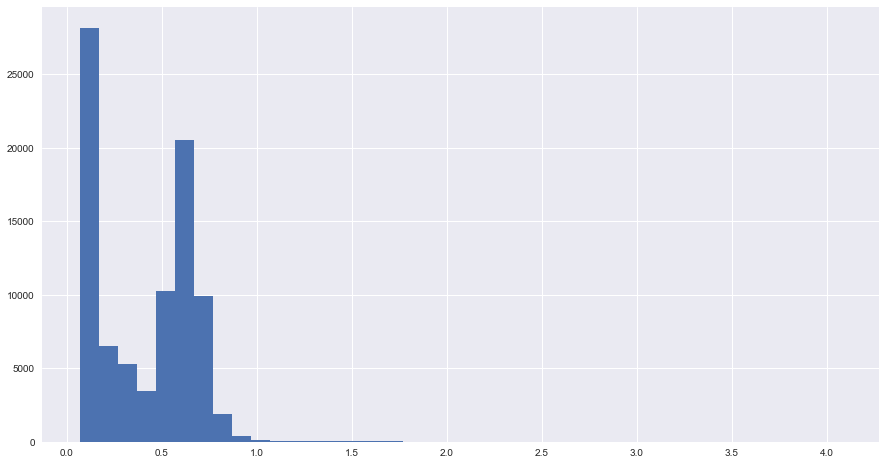

In [6]:
# histogram
plt.figure(figsize=(15,8))
plt.hist(df.GRISEN_NR.values, 40)

In [7]:
df = df.drop(['GRISEN_NR'], axis=1)

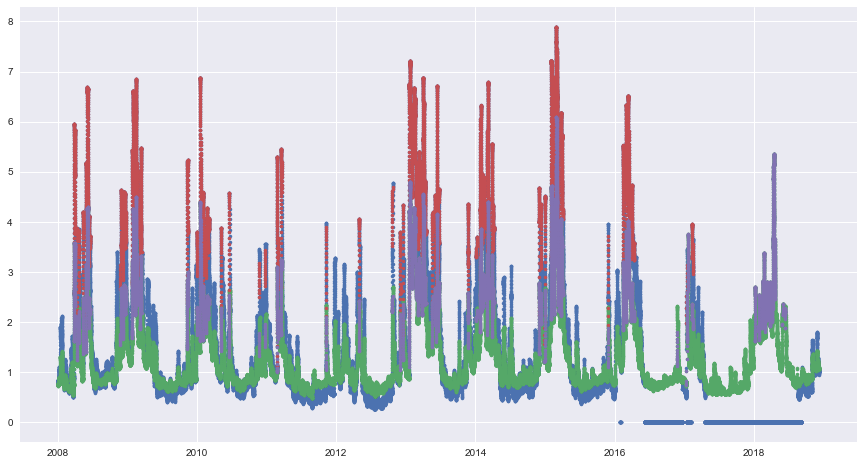

In [8]:
plt.figure(figsize=(15,8))
plt.plot(df.ALAGON_NR.fillna(0), '.')
plt.plot(df.ZGZ_NR.fillna(0), '.')
plt.plot(df[df.RIESGO==1].ALAGON_NR, '.')
plt.plot(df[df.RIESGO==1].ZGZ_NR, '.')

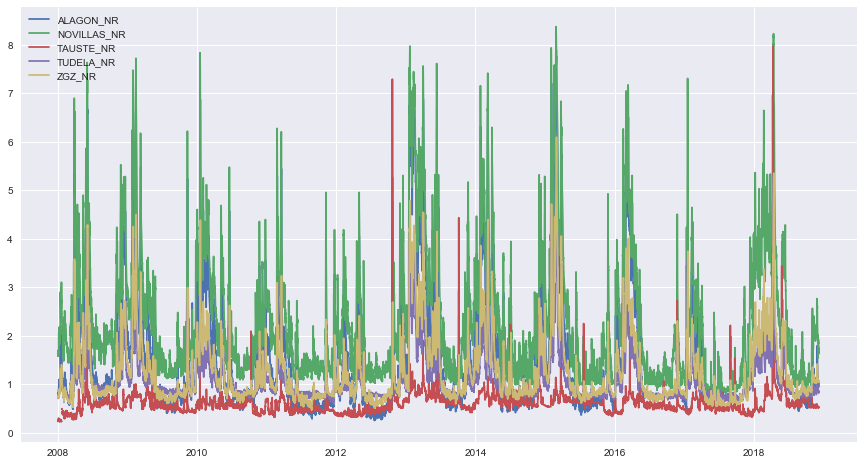

In [9]:
df.iloc[:,:6].plot(figsize=(15,8))

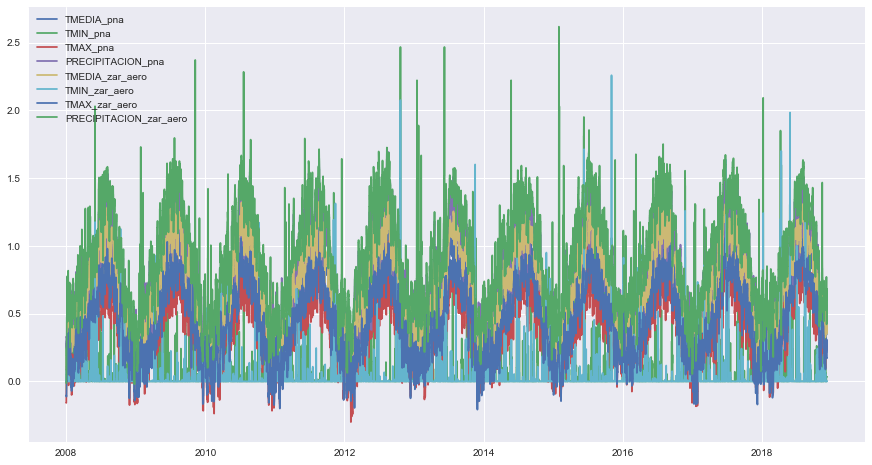

In [10]:
df.iloc[:,9:].plot(figsize=(15,8))

/Users/miloc/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/miloc/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([9.0000e+00, 2.9100e+02, 1.4650e+03, 7.8390e+03, 1.6002e+04,
        1.3943e+04, 9.1700e+03, 7.3110e+03, 4.7190e+03, 4.2870e+03,
        3.6740e+03, 3.0140e+03, 2.8860e+03, 2.3110e+03, 2.4200e+03,
        2.2840e+03, 2.0550e+03, 1.8130e+03, 1.5780e+03, 1.2790e+03,
        1.0770e+03, 1.1150e+03, 8.7500e+02, 7.4000e+02, 5.0300e+02,
        3.6200e+02, 4.3600e+02, 2.9200e+02, 3.6800e+02, 3.8100e+02,
        3.2000e+02, 2.4300e+02, 1.7800e+02, 8.7000e+01, 7.7000e+01,
        7.2000e+01, 2.2000e+01, 2.7000e+01, 1.8000e+01, 3.6000e+01]),
 array([-0.21645372, -0.19186812, -0.16728252, -0.14269692, -0.11811132,
        -0.09352572, -0.06894013, -0.04435453, -0.01976893,  0.00481667,
         0.02940227,  0.05398787,  0.07857347,  0.10315907,  0.12774466,
         0.15233026,  0.17691586,  0.20150146,  0.22608706,  0.25067266,
         0.27525826,  0.29984386,  0.32442945,  0.34901505,  0.37360065,
         0.39818625,  0.42277185,  0.44735745,  0.47194305,  0.49652864,
         0.52111

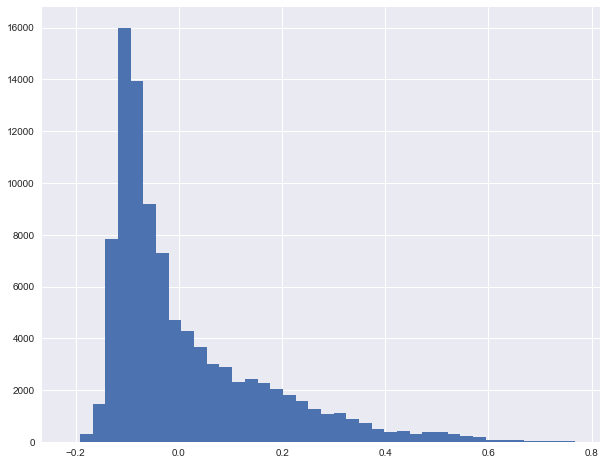

In [11]:
plt.figure(figsize=(10,8))
plt.hist(np.log10(df.TUDELA_NR.values), 40)

In [12]:
#for col in df.columns[:5]:
#    df[col] = np.log10(df[col].values)

## Feature engineering <a class="anchor" id="third-bullet"></a>

In [13]:
# Features
columns_y = ['pred_24h', 'pred_48h', 'pred_72h']
columns_x = [x for x in df.columns if x not in columns_y]

X = df[columns_x]
Y = df[columns_y[2]]

# Create features base on delta to time
cols_delt = columns_x[:5]
hrs = 5

X = bf.delta_height(X, cols_delt, hrs)
#X = bf.shift_columns(X, cols_delt, hrs)

print('Shape:', X.shape)
display(X.tail())

../src/features/build_features.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[name] = delta


Shape: (95856, 19)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,TMEDIA_zar_aero,TMIN_zar_aero,TMAX_zar_aero,PRECIPITACION_zar_aero,delta_ALAGON_NR,delta_NOVILLAS_NR,delta_TAUSTE_NR,delta_TUDELA_NR,delta_ZGZ_NR
2018-12-07 19:00:00,0.9850,1.7300,0.52,0.8450,1.05,False,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6,0.0030,-0.0150,0.0000,0.0005,0.0
2018-12-07 20:00:00,0.9800,1.7475,0.52,0.8450,1.05,False,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6,0.0040,-0.0230,0.0005,0.0005,0.0
2018-12-07 21:00:00,0.9675,1.7500,0.52,0.8375,1.05,False,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6,0.0065,-0.0235,0.0020,0.0010,0.0
2018-12-07 22:00:00,0.9550,1.7400,0.52,0.8300,1.05,False,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6,0.0075,-0.0170,0.0020,0.0040,0.0
2018-12-07 23:00:00,0.9450,1.7375,0.52,0.8300,1.05,False,NaN,0.033333,NaN,0.491667,0.383333,0.0,0.170833,0.6,0.0090,-0.0085,0.0015,0.0040,0.0


## Missing Values <a class="anchor" id="fourth-bullet"></a>

In [14]:
# List the columns that contain missing values
X.isnull().sum()

ALAGON_NR                 16968
NOVILLAS_NR                1468
TAUSTE_NR                   519
TUDELA_NR                   277
ZGZ_NR                        0
RIESGO                        0
TMEDIA_pna                   48
TMIN_pna                     24
TMAX_pna                     24
PRECIPITACION_pna            24
TMEDIA_zar_aero               0
TMIN_zar_aero                 0
TMAX_zar_aero                 0
PRECIPITACION_zar_aero        0
delta_ALAGON_NR           16968
delta_NOVILLAS_NR          1468
delta_TAUSTE_NR             519
delta_TUDELA_NR             277
delta_ZGZ_NR                  0
dtype: int64

In [15]:
# Most simple thing, remove missing values
X = X.dropna()
Y = Y[X.index]
X.isnull().sum()

ALAGON_NR                 0
NOVILLAS_NR               0
TAUSTE_NR                 0
TUDELA_NR                 0
ZGZ_NR                    0
RIESGO                    0
TMEDIA_pna                0
TMIN_pna                  0
TMAX_pna                  0
PRECIPITACION_pna         0
TMEDIA_zar_aero           0
TMIN_zar_aero             0
TMAX_zar_aero             0
PRECIPITACION_zar_aero    0
delta_ALAGON_NR           0
delta_NOVILLAS_NR         0
delta_TAUSTE_NR           0
delta_TUDELA_NR           0
delta_ZGZ_NR              0
dtype: int64

In [16]:
# New features usign the delta
x = X.iloc[:,:5].diff().fillna(0)
x.columns = [x+'_d' for x in X.columns[:5]]
X = pd.concat([X, x], axis=1)

### Split the data in train and test set

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(x_train.shape)
display(pd.DataFrame(x_train).head())

(53939, 24)


,ALAGON_NR,NOVILLAS_NR,TAUSTE_NR,TUDELA_NR,ZGZ_NR,RIESGO,TMEDIA_pna,TMIN_pna,TMAX_pna,PRECIPITACION_pna,...,delta_ALAGON_NR,delta_NOVILLAS_NR,delta_TAUSTE_NR,delta_TUDELA_NR,delta_ZGZ_NR,ALAGON_NR_d,NOVILLAS_NR_d,TAUSTE_NR_d,TUDELA_NR_d,ZGZ_NR_d
2010-04-19 23:00:00,1.1100,2.1025,0.5625,0.9125,1.0200,False,0.645833,0.045833,0.420833,0.870833,...,-0.0105,-0.0295,0.0050,0.0130,-0.0005,0.0000,0.0675,-0.0125,0.0000,0.0000
2008-04-27 15:00:00,1.8200,2.6900,0.4150,1.0800,1.3975,False,0.770833,0.045833,0.475000,1.066667,...,0.0270,0.0005,0.0030,0.0005,0.0080,-0.0275,0.0000,-0.0050,0.0050,-0.0125
2015-09-19 02:00:00,0.6925,1.3025,0.6300,0.7950,0.7975,False,0.620833,0.000000,0.362500,0.879167,...,-0.0085,0.0105,0.0000,0.0030,0.0005,0.0150,-0.0125,0.0000,-0.0050,-0.0025
2011-03-06 23:00:00,2.3125,3.1750,0.4700,1.2300,1.6250,False,0.325000,0.000000,0.012500,0.641667,...,0.0075,0.0050,0.0000,0.0000,0.0010,-0.0175,0.0150,0.0000,0.0000,-0.0025
2010-08-07 21:00:00,0.5400,1.1800,0.5800,0.8200,0.7400,False,0.912500,0.000000,0.487500,1.337500,...,0.0140,-0.0030,-0.0055,-0.0010,-0.0020,-0.0100,0.0000,0.0050,0.0075,0.0000


## Model regressor <a class="anchor" id="fifth-bullet"></a>

In [18]:
## Linear Regressor
regr = LinearRegression()

regr.fit(x_train, y_train)
print('r2_score = %0.3f' % regr.score(x_test, y_test))
print('ECM_score = %0.3f' % ecm(regr.predict(x_test), y_test))

r2_score = 0.888
ECM_score = 0.061


In [19]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

xgb.fit(x_train, y_train)
print('r2_score = %0.3f' % xgb.score(x_test, y_test))
print('ECM_score = %0.3f' % ecm(xgb.predict(x_test), y_test))

r2_score = 0.978
ECM_score = 0.012


### Cross-validation

In [ ]:
kfold = KFold(n_splits=10, random_state=7)
scoring = 'r2'
scores = cross_val_score(regr, X, Y, cv=kfold, scoring=scoring)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.84 (+/- 0.16)


In [ ]:
scores = cross_val_score(xgb, X, Y, cv=kfold, scoring=scoring)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std()))
print('Confidence interval 66%')

In [ ]:
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
print('Confidence interval 95%')

In [ ]:
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2.6))
print('Confidence interval 99%')